Implementing an Autoencoder in PyTorch
===

This is the PyTorch implementing an autoencoder.

First, to install PyTorch, you may use the following pip command,

```
$ pip install torch torchvision
```

The `torchvision` package contains the image data sets that are ready for use in PyTorch.

More details on its installation through [this guide](https://pytorch.org/get-started/locally/) from [pytorch.org](pytorch.org).

## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [3]:
batch_size = 128
epochs = 50
learning_rate = 1e-3

generator1 = torch.Generator().manual_seed(42)

## Dataset

Costum dataset for KITTI sequences.

In [4]:
# Resize to (256 , 256)
transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                            torchvision.transforms.Resize((256, 256)),
                                            torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder('../data_odometry_gray/dataset/sequences/train/00', transform=transform)
train_data_len = int(len(dataset) * 0.9)
test_data_len = len(dataset) - train_data_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_data_len, test_data_len], generator=generator1)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

## CNN_based Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

In [6]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.relu = nn.ReLU()


    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))

        latent = x
        # Decoder
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.relu(self.deconv4(x))
        x = self.deconv5(x)
                
        return x, latent

# initialize the NN
model = ConvAutoencoder()

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [9]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # specify loss function
criterion = nn.MSELoss()

model = ConvAutoencoder().to(device)
model1 = ConvAutoencoder().to(device)
model2 = ConvAutoencoder().to(device)
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train our autoencoder for our specified number of epochs.

In [ ]:
for epoch in range(1, epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        images = images.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        # print(images.shape)
        outputs,_ = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "model_gray_scale.pt")

# Save the model

In [ ]:
file_name = "model.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, file_name)

# Eval

In [32]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)
test_loss = 0.0
for data in test_loader:
    # _ stands in for labels, here
    # no need to flatten images
    images, _ = data
    # clear the gradients of all optimized variables
    # optimizer.zero_grad()
    
    images = images.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    # print(images.shape)
    outputs,_ = model(images)
    # calculate the loss
    loss = criterion(outputs, images)
    # backward pass: compute gradient of the loss with respect to model parameters
    # loss.backward()
    # perform a single optimization step (parameter update)
    # optimizer.step()
    # update running training loss
    test_loss += loss.item()*images.size(0)
    # print(test_loss)
        
# print avg training statistics 
test_loss = test_loss/len(test_loader)
    
print('Test Loss: {:.6f}'.format(
    test_loss
    ))

Test Loss: 0.687393


## Visualize reconstruction results

Let's extract some test examples to reconstruct using our trained autoencoder.

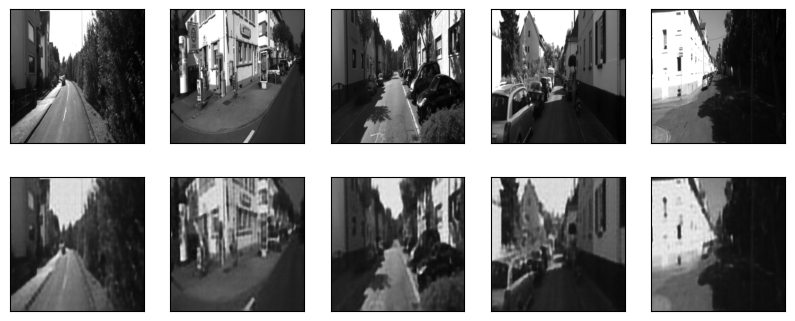

In [13]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
# model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('model_big_10ep.pt')["model_state_dict"])
output, latent = model(images.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 256, 256)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Latent Space Comparison Visualization

False


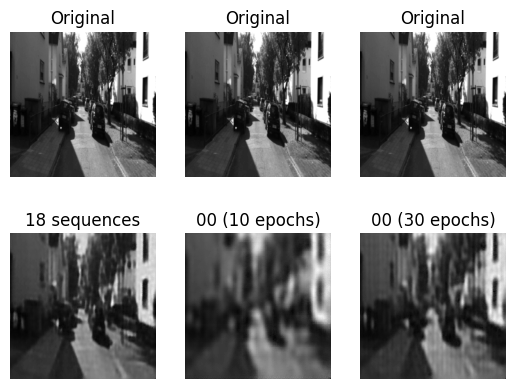

In [10]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
# model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('model_big_10ep.pt')["model_state_dict"])
model1.load_state_dict(torch.load('model_seq0_10ep.pt')["model_state_dict"])
model2.load_state_dict(torch.load('model_seq0_30ep.pt')["model_state_dict"])

output, latent = model(images.to(device))
output1, latent1 = model1(images.to(device))
output2, latent2 = model2(images.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 256, 256)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()
output1 = output1.cpu().detach().numpy()
output2 = output2.cpu().detach().numpy()

fig = plt.figure()
fig.add_subplot(2, 3, 1)
  
# showing image
plt.imshow(images[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 4)
  
# showing image
plt.imshow(output[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("18 sequences")


fig.add_subplot(2, 3, 2)
  
# showing image
plt.imshow(images[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 5)
  
# showing image
plt.imshow(output1[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("00 (10 epochs)")

fig.add_subplot(2, 3, 3)
  
# showing image
plt.imshow(images[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 6)
  
# showing image
plt.imshow(output2[0].transpose((1,2,0)), cmap='gray')
plt.axis('off')
plt.title("00 (30 epochs)")

print(torch.equal(latent1, latent))